# Polymer Properties Optimising the Neural Network

**Optimising the NN and continue to diverge from the original publciation thus we acknolwege only the dataset**
Data taken from: Estimation and Prediction of the Polymers’ Physical Characteristics Using the Machine Learning Models Polymers 2024, 16(1), 115; https://doi.org/10.3390/polym16010115.

Github repository: https://github.com/catauggie/polymersML/tree/main

We are going to tunr the MLP ANN to see how close to 1 we can get the $R^2$ value and how low we can get the AME.

In [1]:
import tensorflow as tf
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)
    


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


In [2]:
# Go ahead and import the data into a dataframe and then make sure its imported properly by listing the first few lines
import pandas as pd
new_df = pd.read_excel('Tg_Data_Frame.xlsx')
new_df.head(3)

,Unnamed: 0,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,...,col_1015,col_1016,col_1017,col_1018,col_1019,col_1020,col_1021,col_1022,col_1023,Glass transition temperature_value_median
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-60.00
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.39
2,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-24.05


In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LeakyReLU

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score, median_absolute_error

In [4]:
# Function Definitions
def evaluate_model_performance(y_test, y_pred):
    """
    Evaluate the performance of a model using various metrics.
    
    Parameters:
    - y_test: array-like of shape (n_samples,) or (n_samples, n_outputs), 
              True values for X.
    - y_pred: array-like of shape (n_samples,) or (n_samples, n_outputs),
              Estimated target values.
    """
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    variance_score = explained_variance_score(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)

    print(f'Mean Squared Error: {mse:.3f}')
    print(f'R-squared: {r2:.3f}')
    print(f'Mean Absolute Error: {mae:.3f}')
    print(f'Explained Variance Score: {variance_score:.3f}')
    print(f'Median Absolute Error: {medae:.3f}')

# Example usage:
# y_test = [actual values]
# y_pred = [predicted values]
# evaluate_model_performance(y_test, y_pred)


def plot_actual_vs_predicted(y_test, y_pred):
    """
    Plot the actual vs. predicted values to evaluate a model's performance.
    
    Parameters:
    - y_test: array-like, True values.
    - y_pred: array-like, Predicted values.
    """
    plt.figure(figsize=(10, 6))  # Set the figure size for better readability

    # Scatter plot for actual vs. predicted values
    plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs. Actual')

    # Ideal line for perfect predictions
    max_val = max(max(y_test), max(y_pred))  # Find the maximum value for setting plot limits
    min_val = min(min(y_test), min(y_pred))  # Find the minimum value for setting plot limits
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Ideal Fit')

    # Customization and labels
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Model Predictions vs. Actual Data')
    plt.legend()
    plt.grid(True)

    # Show plot
    plt.show()

# Example usage:
# y_test = [actual values]
# y_pred = [predicted values]
# plot_actual_vs_predicted(y_test, y_pred)

def bland_altman_plot(y_test, y_pred):
    """
    Generate a Bland-Altman plot to assess the agreement between two sets of measurements.
    
    Parameters:
    - y_test: array-like, true values.
    - y_pred: array-like, predicted values.
    """
    avg = (y_test + y_pred) / 2
    diff = y_test - y_pred

    plt.figure(figsize=(10, 6))
    plt.scatter(avg, diff, alpha=0.5)
    plt.axhline(y=np.mean(diff), color='r', linestyle='--', label='Mean Difference')
    plt.axhline(y=np.mean(diff) + 1.96 * np.std(diff), color='g', linestyle='--', label='Upper Limit of Agreement')
    plt.axhline(y=np.mean(diff) - 1.96 * np.std(diff), color='g', linestyle='--', label='Lower Limit of Agreement')
    plt.xlabel('Average of Actual and Predicted Values')
    plt.ylabel('Difference Between Actual and Predicted Values')
    plt.title('Bland-Altman Plot')
    plt.legend()
    plt.show()

# Example usage:
# y_test = [actual values]
# y_pred = [predicted values]
# bland_altman_plot(y_test, y_pred)

In [5]:
# X and y data 
cols = [c for c in new_df.columns if 'col' in c]
X = new_df[cols]
y = new_df['Glass transition temperature_value_median']

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# It's important to scale the features because neural networks are sensitive to input scale
scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test) 

In [7]:
# Updated model architecture
model = Sequential([
    Dense(128, input_dim=X_train.shape[1]),  # Increased the number of neurons
    LeakyReLU(alpha=0.01),  # Using LeakyReLU to avoid dead neurons
    BatchNormalization(),
    Dropout(0.1),
    
    Dense(256),  # Increased layer size and depth
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(128),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(1, activation='linear')
])

# Adjust initial learning rate
initial_learning_rate = 0.001  # Lowered to start with a more conservative approach

# Use a learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

# Updated optimizer with learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile the model with the new optimizer and learning rate schedule
model.compile(optimizer=optimizer, 
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

# Add early stopping and reduce learning rate on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, mode='min', verbose=1)

# Summary of the model to see the updated architecture
model.summary()

# Train the model with callbacks
model.fit(X_train, y_train_scaled, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping, reduce_lr])

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test_scaled)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

2024-02-23 20:29:26.072722: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-02-23 20:29:26.072744: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-02-23 20:29:26.072748: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-02-23 20:29:26.072775: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-23 20:29:26.072787: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131200    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                        

2024-02-23 20:29:26.782034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-02-23 20:29:26.831437: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


162/162 [==============================] - 4s 17ms/step - loss: 1.2066 - mean_absolute_error: 0.8431 - val_loss: 0.5454 - val_mean_absolute_error: 0.6005 - lr: 0.0010
Epoch 2/100
162/162 [==============================] - 2s 15ms/step - loss: 0.4650 - mean_absolute_error: 0.5311 - val_loss: 0.3201 - val_mean_absolute_error: 0.4478 - lr: 0.0010
Epoch 3/100
162/162 [==============================] - 2s 15ms/step - loss: 0.3084 - mean_absolute_error: 0.4328 - val_loss: 0.1946 - val_mean_absolute_error: 0.3306 - lr: 0.0010
Epoch 4/100
162/162 [==============================] - 2s 15ms/step - loss: 0.2447 - mean_absolute_error: 0.3849 - val_loss: 0.1748 - val_mean_absolute_error: 0.3143 - lr: 0.0010
Epoch 5/100
162/162 [==============================] - 2s 15ms/step - loss: 0.1946 - mean_absolute_error: 0.3430 - val_loss: 0.1817 - val_mean_absolute_error: 0.3196 - lr: 0.0010
Epoch 6/100
162/162 [==============================] - 2s 15ms/step - loss: 0.1692 - mean_absolute_error: 0.3179 - va

In [11]:
predictions = model.predict(X_test)
predictions = predictions.ravel()
y_pred_real = scaler.inverse_transform(predictions.reshape(-1, 1))
y_pred_real
# Assuming you've already made predictions with your model

evaluate_model_performance(y_test, y_pred_real)

51/51 [==============================] - 0s 3ms/step
Mean Squared Error: 1593.358
R-squared: 0.870
Mean Absolute Error: 27.988
Explained Variance Score: 0.870
Median Absolute Error: 20.006


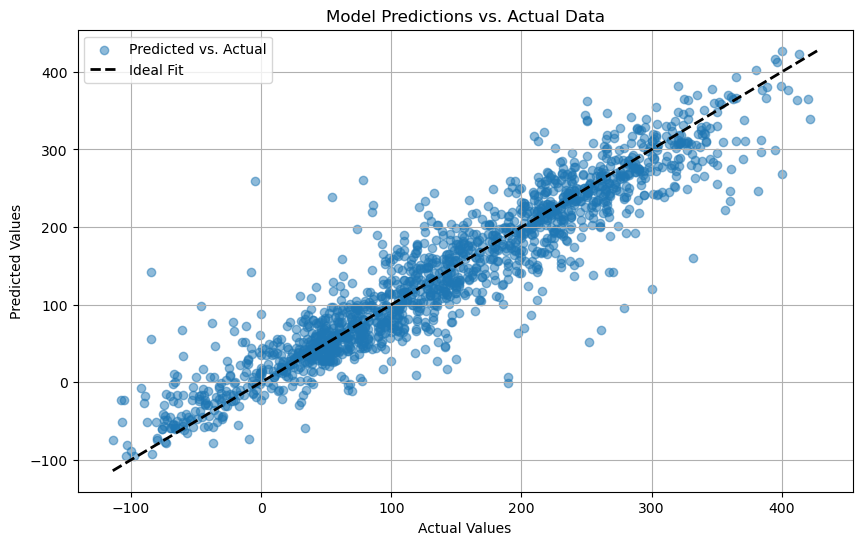

In [12]:
# Visualize the actual vs. predicted values
plot_actual_vs_predicted(y_test, y_pred_real)

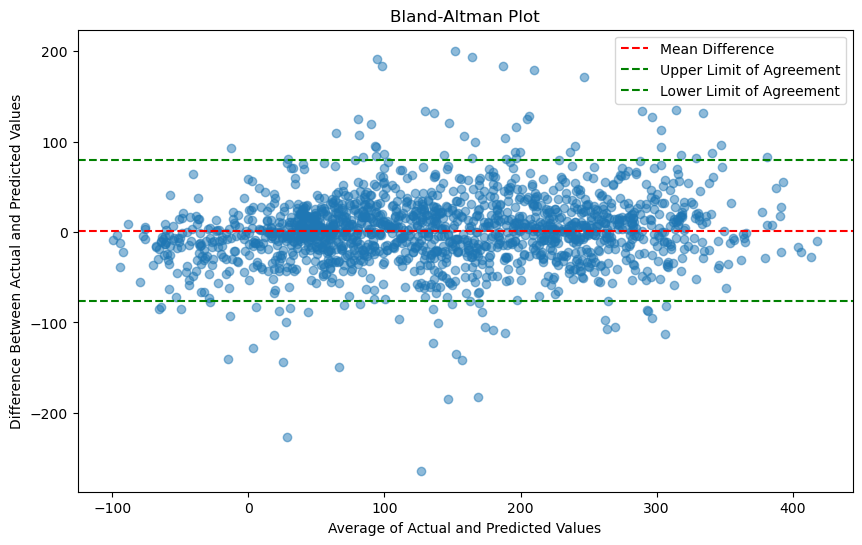

In [13]:
# Generate a Bland-Altman plot
bland_altman_plot(y_test, y_pred_real)

In [51]:
# Updated model architecture
model = Sequential([
    Dense(132, input_dim=X_train.shape[1]),  # Increased the number of neurons
    LeakyReLU(alpha=0.01),  # Using LeakyReLU to avoid dead neurons
    BatchNormalization(),
    Dropout(0.1),
    
    Dense(256),  # Increased layer size and depth
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(132),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(8),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(1, activation='linear')
])

# Adjust initial learning rate
initial_learning_rate = 0.01  # Lowered to start with a more conservative approach

# Use a learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=5000,
    decay_rate=0.9,
    staircase=True)

# Updated optimizer with learning rate schedule
optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)

# Compile the model with the new optimizer and learning rate schedule
model.compile(optimizer=optimizer, 
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

# Add early stopping and reduce learning rate on plateau
early_stopping = EarlyStopping(monitor='val_mean_absolute_error', patience=10, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=5, min_lr=0.0001, mode='min', verbose=1)

# Summary of the model to see the updated architecture
model.summary()

# Train the model with callbacks
model.fit(X_train, y_train_scaled, validation_split=0.2, epochs=1000, batch_size=32, callbacks=[early_stopping, reduce_lr])

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test_scaled)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_61 (Dense)            (None, 132)               135300    
                                                                 
 leaky_re_lu_47 (LeakyReLU)  (None, 132)               0         
                                                                 
 batch_normalization_47 (Ba  (None, 132)               528       
 tchNormalization)                                               
                                                                 
 dropout_47 (Dropout)        (None, 132)               0         
                                                                 
 dense_62 (Dense)            (None, 256)               34048     
                                                                 
 leaky_re_lu_48 (LeakyReLU)  (None, 256)               0         
                                                     

In [52]:
predictions = model.predict(X_test)
predictions = predictions.ravel()
y_pred_real = scaler.inverse_transform(predictions.reshape(-1, 1))
y_pred_real
# Assuming you've already made predictions with your model

evaluate_model_performance(y_test, y_pred_real)

51/51 [==============================] - 1s 6ms/step
Mean Squared Error: 1444.866
R-squared: 0.882
Mean Absolute Error: 26.306
Explained Variance Score: 0.882
Median Absolute Error: 18.198


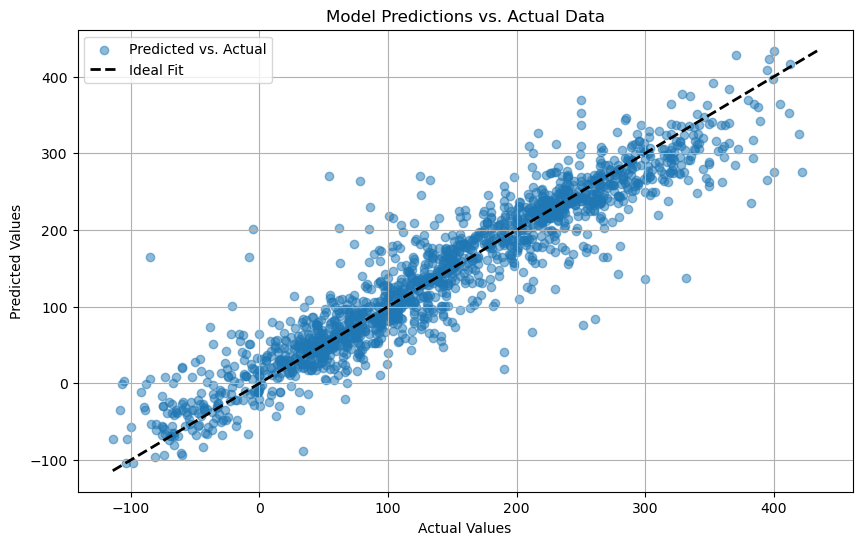

In [53]:
# Visualize the actual vs. predicted values
plot_actual_vs_predicted(y_test, y_pred_real)

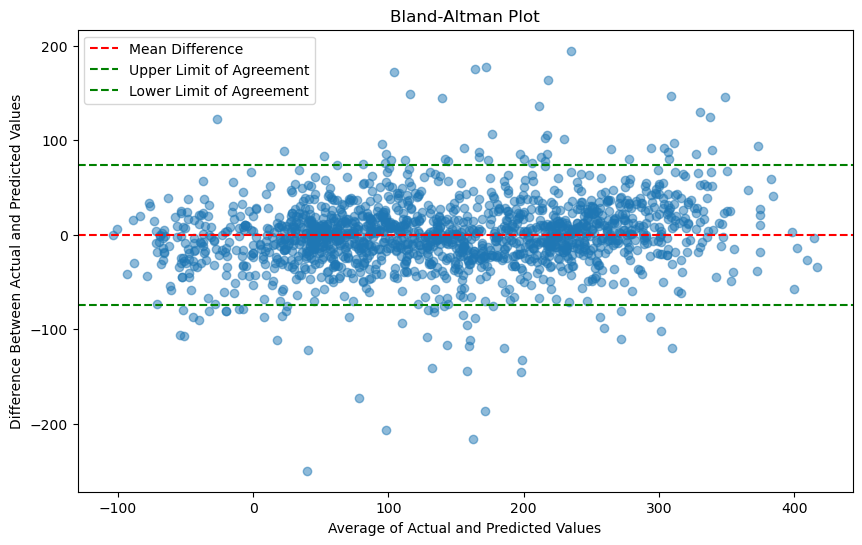

In [54]:
# Generate a Bland-Altman plot
bland_altman_plot(y_test, y_pred_real)